In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

2025-05-03 05:37:23.474596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746250643.732744      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746250643.810729      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.__version__

'2.18.0'

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification


In [5]:
import os

count = 0
dir_path = os.listdir('/kaggle/input/garbage-classification/garbage_classification')
dir_path

for dir in dir_path:
    files = list(os.listdir('/kaggle/input/garbage-classification/garbage_classification/'+dir))
    print(f"{dir} folder has {str(len(files))} images")
    count = count + len(files)
    
print(f"Garbage_classification has {str(count)} Images.")

metal folder has 769 images
white-glass folder has 775 images
biological folder has 985 images
paper folder has 1050 images
brown-glass folder has 607 images
battery folder has 945 images
trash folder has 697 images
cardboard folder has 891 images
shoes folder has 1977 images
clothes folder has 5325 images
plastic folder has 865 images
green-glass folder has 629 images
Garbage_classification has 15515 Images.


In [6]:
directory = '/kaggle/input/garbage-classification/garbage_classification/'
train_data = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(256, 256),
    batch_size=32
)

val_data = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(256, 256),
    batch_size=32
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.


I0000 00:00:1746250664.903084      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


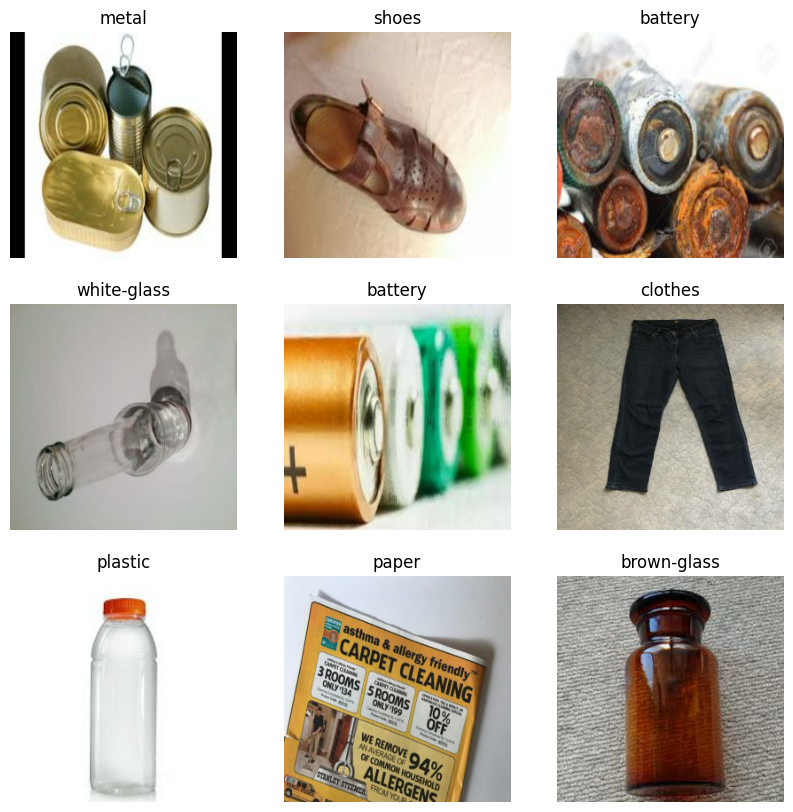

In [7]:

garbage_names = train_data.class_names
i=0
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
    for i in range (9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(garbage_names[labels[i]])
        plt.axis('off')
plt.show()

In [8]:
garbage_names = train_data.class_names


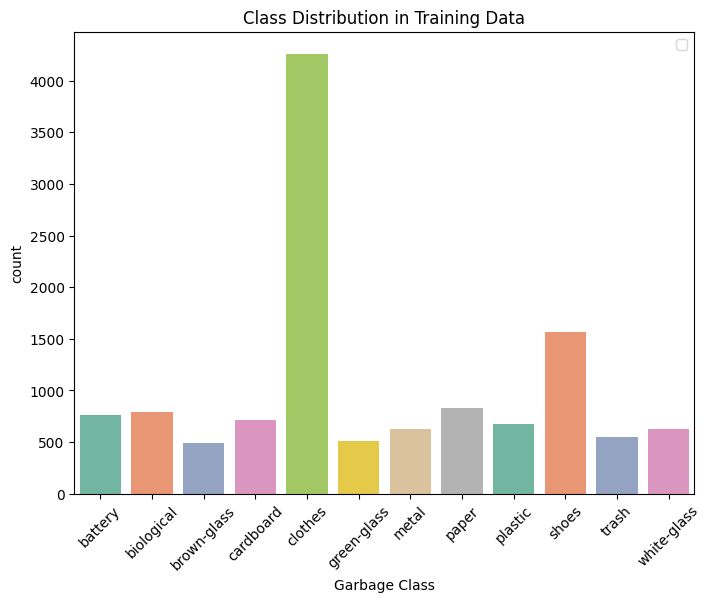

In [9]:
all_labels = []

for images,labels in train_data:
    all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)

plt.figure(figsize=(8,6))
sns.countplot(x=all_labels,palette='Set2')

plt.xticks(ticks = range(len(garbage_names)), labels = garbage_names, rotation = 45)

plt.xlabel('Garbage Class')
# plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.legend()
plt.show()

## Optimization and Memory cache

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)

In [12]:
val_data_data = val_data.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)


In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,Dropout,Flatten,MaxPool2D

## Efficient Model And Data Augmentation

In [14]:
eff_net_model = tf.keras.applications.EfficientNetV2S(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

eff_net_model.trainable = False

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # This replaces RandomRotation with random translation
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
# model = keras.models.Sequential([
#     data_augmentation,
#     eff_net_model,
#     layers.GlobalAveragePooling2D(),
#     # layers.Flatten(),
#     layers.Dropout(0.25),
#     layers.Dense(125,activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dense(len(garbage_names),activation = "softmax")
# ])

## Model Creation and layers

In [17]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input


In [18]:
inputs = keras.Input(shape=(256,256,3))

x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)
x = preprocess_input(x)
x = eff_net_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(125,activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(len(garbage_names),activation = "softmax")(x)

model = keras.Model(inputs = inputs, outputs = outputs)


In [19]:
model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.2, patience = 3)
early_stopping = EarlyStopping(monitor  = 'val_loss',patience =10, restore_best_weights = True)

In [21]:
epochs_size = 10
history = model.fit(train_data,validation_data=val_data,epochs=epochs_size,batch_size=100,verbose=1,callbacks=[lr_scheduler,early_stopping])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
E0000 00:00:1746250728.503523      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746250749.229713      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


388/388 ━━━━━━━━━━━━━━━━━━━━ 114s 153ms/step - accuracy: 0.8173 - loss: 0.5898 - val_accuracy: 0.9565 - val_loss: 0.1512 - learning_rate: 0.0010
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.9439 - loss: 0.1774 - val_accuracy: 0.9523 - val_loss: 0.1611 - learning_rate: 0.0010
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 51s 132ms/step - accuracy: 0.9545 - loss: 0.1444 - val_accuracy: 0.9604 - val_loss: 0.1294 - learning_rate: 0.0010
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 51s 132ms/step - accuracy: 0.9633 - loss: 0.1161 - val_accuracy: 0.9600 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.9681 - loss: 0.1037 - val_accuracy: 0.9626 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.9673 - loss: 0.0977 - val_accuracy: 0.9620 - val_loss: 0.1291 - learning_rate: 0.0010
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 51s 132ms/step - accuracy: 0.9734 - loss

In [22]:
model.evaluate(val_data)

97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9629 - loss: 0.1275


[0.1194492056965828, 0.9674508571624756]

In [23]:
model.save('garbage_model.keras')

In [24]:
mdl=keras.models.load_model('/kaggle/working/garbage_model.keras')

In [25]:
mdl.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 8, 8, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 125)                 │         160,125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 125)                 │             500 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,817,273 (79.41 MB)

 Trainable params: 161,887 (632.37 KB)

 Non-trainable params: 20,331,610 (77.56 MB)

 Optimizer params: 323,776 (1.24 MB)


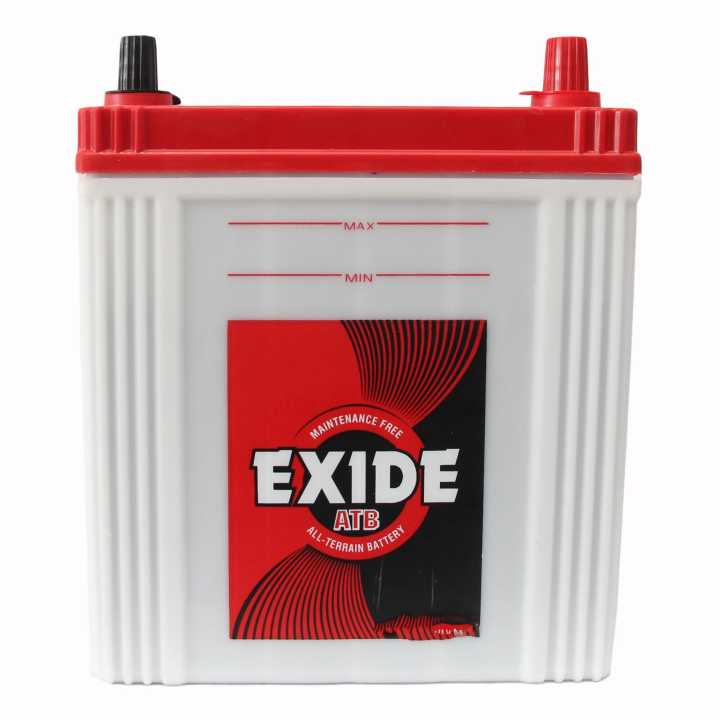

In [26]:
img = '/kaggle/input/unseen-image/battery.jpg'
img = tf.keras.utils.load_img(img,target_size=(256,256))
img_arr = tf.keras.utils.array_to_img(img)
img_bat = tf.expand_dims(img_arr,0)

In [27]:
predict = mdl.predict(img_bat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [28]:
garbage_names[np.argmax(predict)]

'plastic'

In [29]:
print(f"The model predicted: {garbage_names[np.argmax(predict)]}")

The model predicted: plastic


In [30]:
print(score)

NameError: name 'score' is not defined

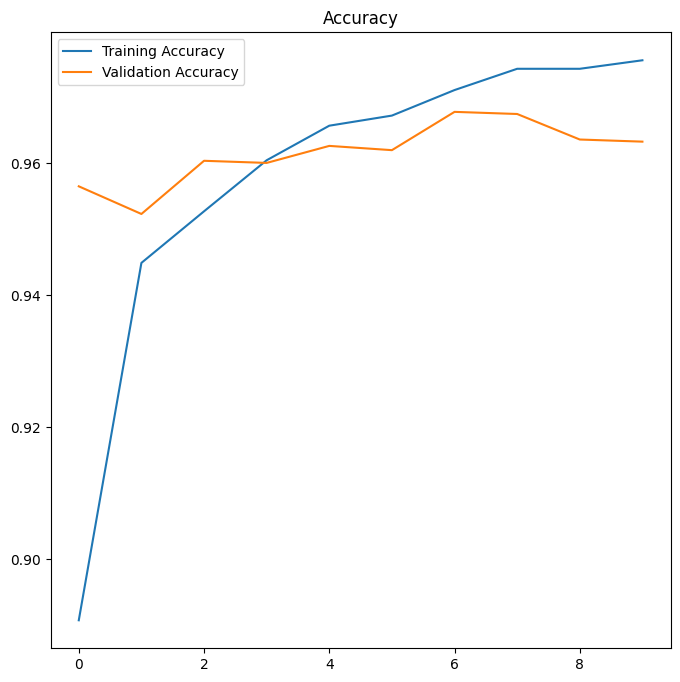

In [31]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
# plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label='Training Accuracy')
plt.plot(epochs_range,history.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Accuracy')

plt.legend()
plt.show()



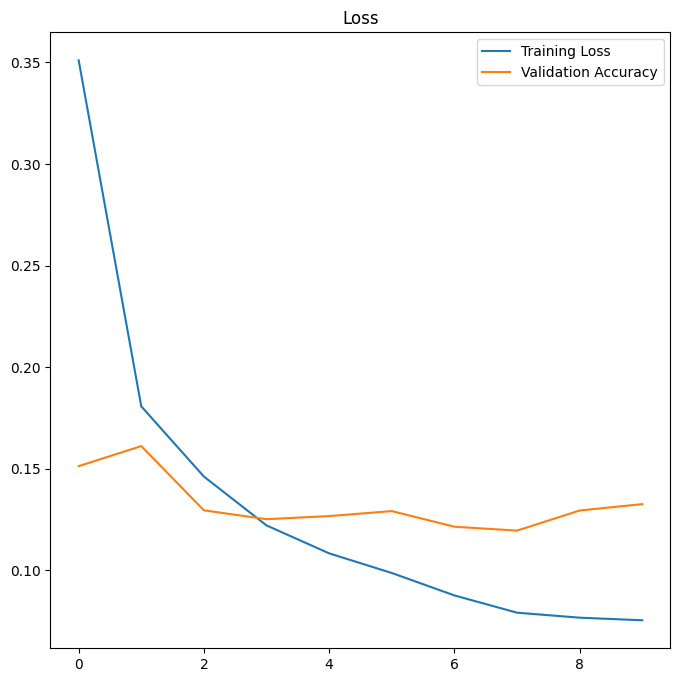

In [32]:
plt.figure(figsize=(8,8))
# plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label='Training Loss')
plt.plot(epochs_range,history.history['val_loss'],label= 'Validation Accuracy')
plt.title('Loss')

plt.legend()
plt.show()